In [26]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers, optimizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
import os
import statistics
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", None)

In [10]:
benign_path = '/home/sdsra/Downloads/CTU-Dataset/benign'
benign_datas = pd.DataFrame()
sub_dir_list = os.listdir(benign_path)
for dir in sub_dir_list:
    tmp_data = pd.read_pickle(benign_path + '/' + dir + '/datas-by-origin-tool.pkl')
    benign_datas = pd.concat([benign_datas, tmp_data], ignore_index=True)

In [11]:
malware_path = '/home/sdsra/Downloads/CTU-Dataset/malware-2' 
malware_datas = pd.DataFrame()
for dir in os.listdir(malware_path) :
    pkl_path = malware_path +'/'+dir+'/datas-by-origin-tool.pkl'
    if os.path.exists(pkl_path):
        tmp_data = pd.read_pickle(pkl_path)
        malware_datas = pd.concat([malware_datas, tmp_data], ignore_index=True)

In [72]:
benign_datas.to_pickle('/home/sdsra/PycharmProjects/feature-extractor/src/data/benign.pkl')

In [73]:
malware_datas.to_pickle('/home/sdsra/PycharmProjects/feature-extractor/src/data/malware2.pkl')

In [12]:
malware_datas = malware_datas[malware_datas['label'] == 'botnet']

In [13]:
benign_datas['is_malware'] = 0

In [14]:
malware_datas['is_malware'] = 1

In [17]:
numeric_columns = list(filter(lambda x: x not in ['src_ip','src_port','dst_ip','dst_port','proto', 'label'], benign_datas.columns))

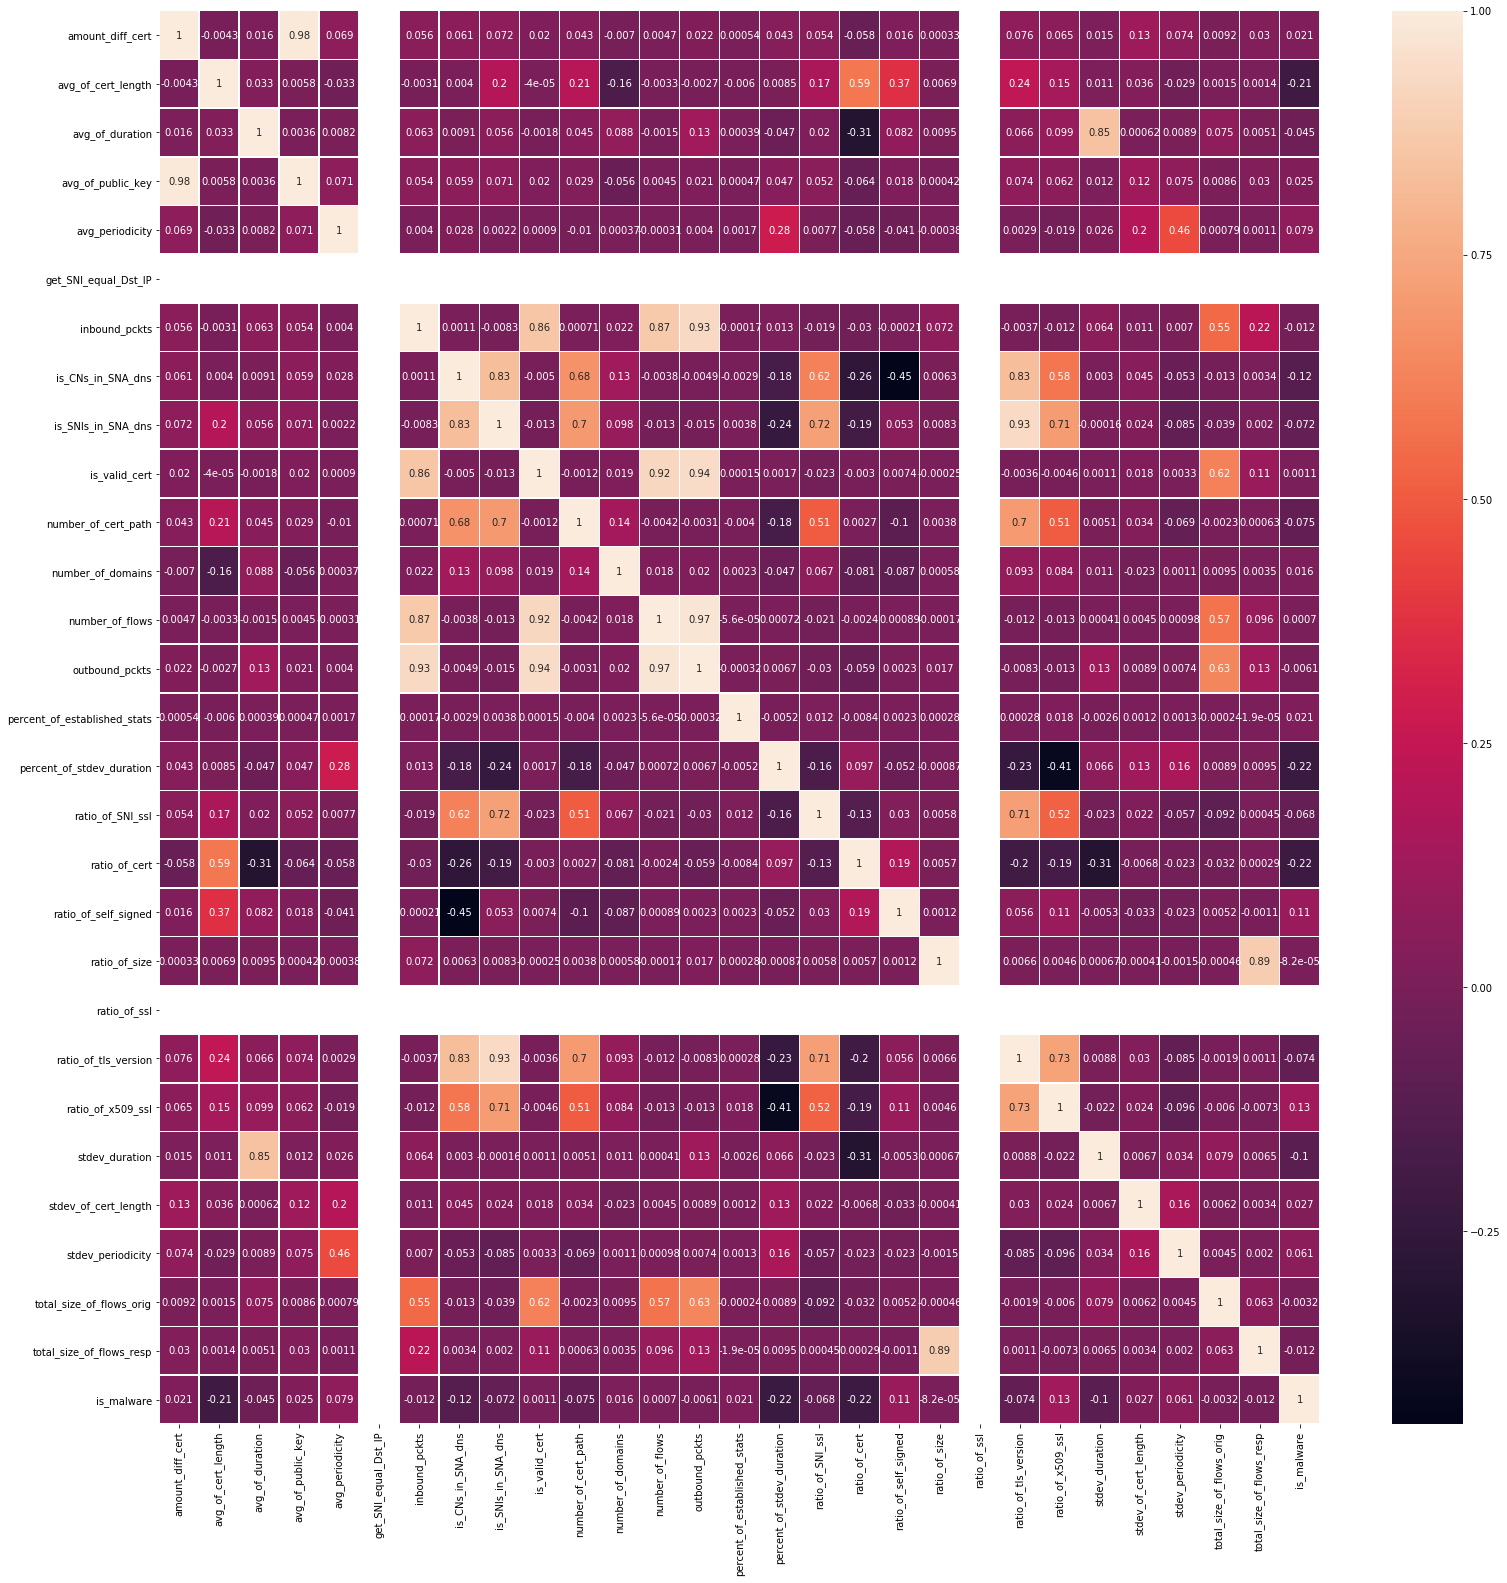

In [18]:
plt.figure(figsize=(26, 26))
sns.heatmap(datas.corr(), annot=True, linewidths=.5)

In [48]:
datas = benign_datas

In [49]:
datas_train, datas_test = train_test_split(datas,test_size=0.2, random_state = 101)

In [50]:
ss = StandardScaler()

In [51]:
ss.fit(datas_train[numeric_columns])

/home/sdsra/anaconda3/envs/gep-gpu/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [52]:
X_train = ss.transform(datas_train[numeric_columns])

/home/sdsra/anaconda3/envs/gep-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [53]:
X_test = ss.transform(datas_test[numeric_columns])

/home/sdsra/anaconda3/envs/gep-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


# OC-SVM

In [54]:
oc_svm_clf = OneClassSVM(gamma=0.001, kernel='rbf', nu=0.08)

In [55]:
if_cls = IsolationForest(contamination=0.08, max_features=1.0, max_samples=1.0, n_estimators=40)

In [56]:
oc_svm_clf.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.001, kernel='rbf',
      max_iter=-1, nu=0.08, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [57]:
if_cls.fit(X_train)

/home/sdsra/anaconda3/envs/gep-gpu/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination=0.08,
        max_features=1.0, max_samples=1.0, n_estimators=40, n_jobs=None,
        random_state=None, verbose=0)

In [58]:
oc_svm_preds = oc_svm_clf.predict(X_test)
if_preds = if_cls.predict(X_test)

In [59]:
datas_test['oc_svm_pred'] = oc_svm_preds

/home/sdsra/anaconda3/envs/gep-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [60]:
datas_test['if_pred'] = if_preds

/home/sdsra/anaconda3/envs/gep-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [61]:
datas_test['oc_svm_pred'].value_counts()

 1    2378
-1     217
Name: oc_svm_pred, dtype: int64

In [62]:
datas_test['if_pred'].value_counts()

 1    2401
-1     194
Name: if_pred, dtype: int64

# Malware Test

In [63]:
scaled_malware_datas = ss.transform(malware_datas[numeric_columns])

/home/sdsra/anaconda3/envs/gep-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [67]:
oc_svm_pred_malware = oc_svm_clf.predict(scaled_malware_datas)

In [68]:
if_pred_malware = if_cls.predict(scaled_malware_datas)

In [65]:
malware_datas['oc_svm_pred'] = oc_svm_pred_malware

In [69]:
malware_datas['if_pred'] = if_pred_malware

In [70]:
malware_datas['oc_svm_pred'].value_counts()

 1    53748
-1    17661
Name: oc_svm_pred, dtype: int64

In [71]:
malware_datas['if_pred'].value_counts()

 1    58275
-1    13134
Name: if_pred, dtype: int64

In [ ]:
|